# Кластеризация

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
from os import path
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# plots
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%pylab inline
%config InlineBackend.figure_format = 'png'
rcParams['figure.figsize'] = (16, 6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
!ls

geo.ipynb        geo.xlsx         geo_comment.xlsx


In [4]:
geo = pd.read_excel('geo.xlsx')
geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108806 entries, 0 to 108805
Data columns (total 3 columns):
x                108806 non-null float64
y                108806 non-null float64
comment_class    108806 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB


In [5]:
geo.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [6]:
geo_comment = pd.read_excel('geo_comment.xlsx')
geo_comment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70382 entries, 0 to 70381
Data columns (total 5 columns):
x                70382 non-null float64
y                70382 non-null float64
comment_class    70382 non-null int64
multiplier       70382 non-null int64
comment          70382 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 3.2+ MB


In [7]:
geo_comment.head()

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


> визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)

In [8]:
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [9]:
X = geo[['x', 'y']].drop_duplicates()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2542 entries, 0 to 108794
Data columns (total 2 columns):
x    2542 non-null float64
y    2542 non-null float64
dtypes: float64(2)
memory usage: 59.6 KB


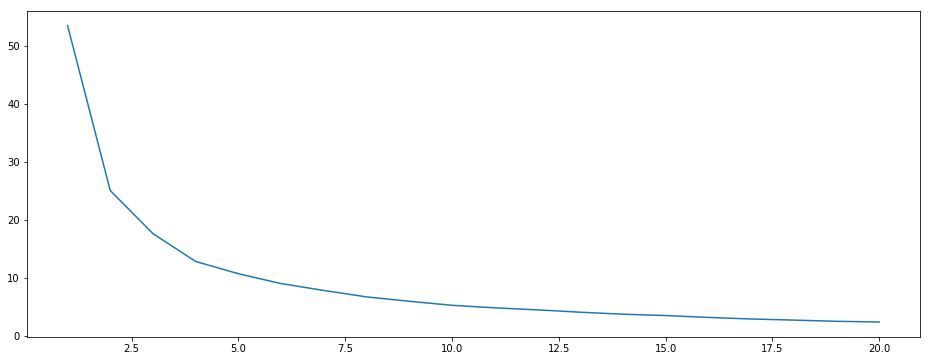

In [10]:
k_inertia = []
ks = range(1,21)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X, )
    k_inertia.append(clf_kmeans.inertia_)

plt.plot(ks, k_inertia)

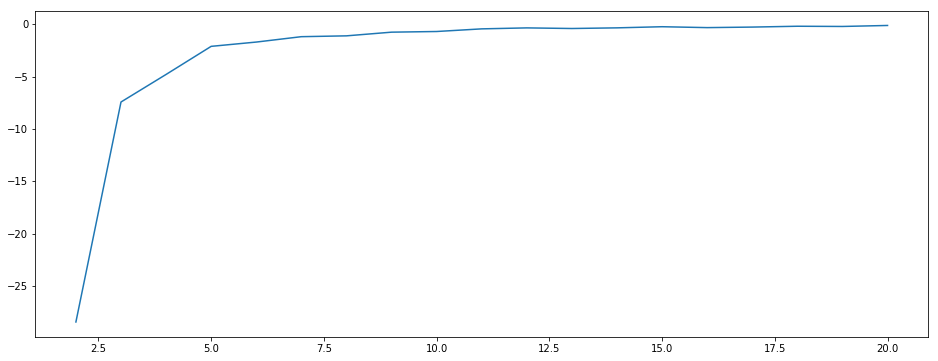

In [11]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

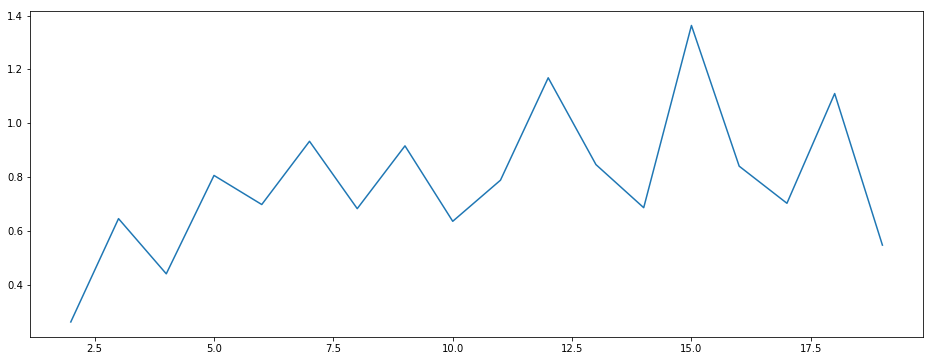

In [12]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

> подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)

In [13]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

2

In [14]:
n_clusters = 10

In [15]:
algorithms = [
    KMeans(n_clusters=n_clusters, n_jobs=-1),
    DBSCAN(eps=0.01, min_samples=10, n_jobs=-1),
    AgglomerativeClustering(n_clusters=n_clusters),
    AffinityPropagation(),
]

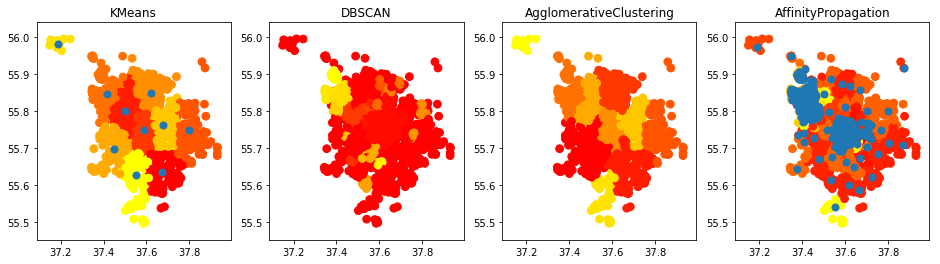

In [16]:
fig, axes = plt.subplots(1, len(algorithms), figsize=(16, 4))

clusters = dict()

for ax, algorithm in zip(axes, algorithms):
    cluster = algorithm.fit_predict(X)
    clusters[algorithm.__class__.__name__] = cluster
    
    ax.scatter(X['x'], X['y'], c=cluster, cmap='autumn', s=60)
    ax.set_title(algorithm.__class__.__name__)
    
    if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=50)

In [17]:
X_with_clusters = X.copy()
X_with_clusters.loc[:, 'cluster'] = clusters['KMeans']
X_with_clusters.head()

,x,y,cluster
0,37.612416,55.777454,2
2,37.603298,55.742108,2
3,37.558526,55.728758,2
4,37.566431,55.731794,2
7,37.558957,55.723399,2


> аналогично исследовать скопления голосов за и против отдельно

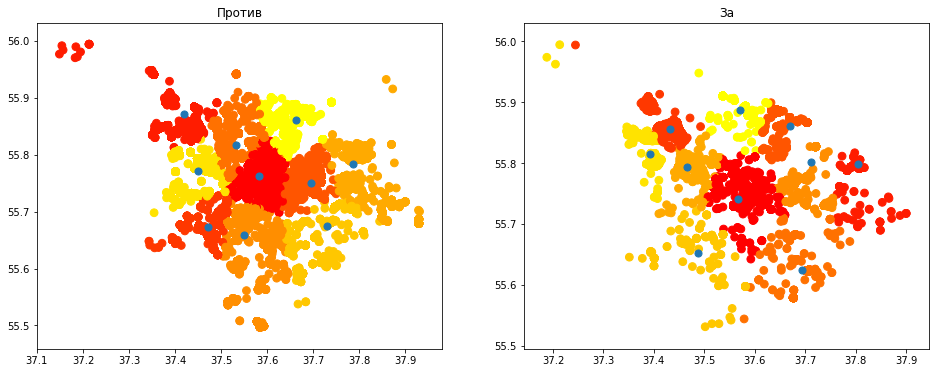

In [18]:
geo_grouped = geo.groupby(['comment_class'])

fig, axes = plt.subplots(1, geo_grouped.ngroups)

for ax, (key, group) in zip(axes, geo_grouped):
    algorithm = KMeans(n_clusters, n_jobs=-1)
    cluster_pred = algorithm.fit_predict(group[['x', 'y']])
    ax.scatter(group['x'], group['y'], c=cluster_pred, cmap='autumn', s=60)
    ax.set_title('За' if key == 1 else 'Против')
    centers = algorithm.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], s=50)

> найти наиболее активные в голосовании районы (подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')

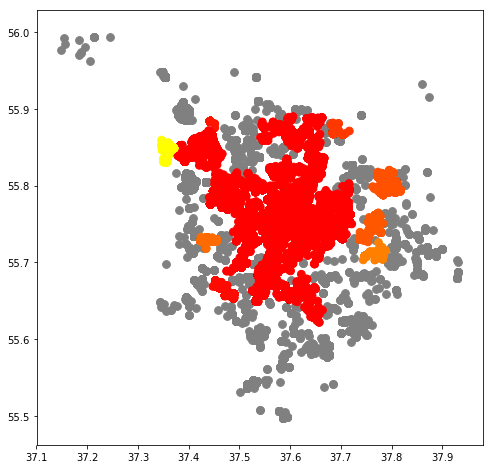

In [21]:
X = geo[['x', 'y']]
algorythm = DBSCAN(eps=0.01, min_samples=10, n_jobs=-1)
cluster_pred = algorythm.fit_predict(X)
fig, axes = plt.subplots(1, 1, figsize=(8,8))

clusters, cluster_counts = np.unique(cluster_pred, return_counts=True)
high_density_clusters = clusters[np.where(cluster_counts >= 1000)]
low_density_clusters = clusters[np.where(cluster_counts < 1000)]

colors = []

X.loc[:, 'cluster'] = cluster_pred
X.loc[:, 'high_density'] = [c in high_density_clusters for c in cluster_pred]
low = X[X['high_density'] == False]
axes.scatter(low.x, low.y, c='grey', s=60)
high = X[X['high_density'] == True]
axes.scatter(high.x, high.y, c=high.cluster, cmap='autumn', s=60)